In [1]:
RANDOM_STATE = 42

import Bias
import BayesianNetwork
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
def generate_toy_data(n):
    bn = BayesianNetwork.BayesianNetwork()
    
    bn.addNode("sex")
    bn.addNode("income")
    bn.addNode("history")
    bn.addNode("loan")
    
    bn.addEdge("income", "loan")
    bn.addEdge("history", "loan")
    
    bn.addProbability("sex", [0.5, 0.5], 2) # 50/50 men/women
    bn.addProbability("history", [0.3, 0.7], 2) # 30% has defaulted in the pat
    bn.addProbability("income", [0.7, 0.3], 2) # 30% is classified as high income
    bn.addCpd("loan", ["history", "income"], [[0.7, 0.5, 0.5, 0.3], [0.3, 0.5, 0.5, 0.7]])
    
    bn._network.check_model()
    
    generator = Bias.DataGenerator(data_generator=bn, protected_attributes=["sex"], labels=["loan"])
    return generator.simulate(n, seed=RANDOM_STATE)

d=generate_toy_data(1_000_000)
print(d.df(weight=False).groupby(["history", "income", "loan", "sex"]).value_counts())
print(d.metrics().disparate_impact())
print(d.metrics().mean_difference())

  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


history  income  loan  sex
0        0       0     0       73371
                       1       73362
                 1     0       31476
                       1       31474
         1       0     0       22223
                       1       22507
                 1     0       22635
                       1       22472
1        0       0     0      123020
                       1      122891
                 1     0      122819
                       1      122715
         1       0     0       31291
                       1       31424
                 1     0       73405
                       1       72915
dtype: int64
1.0020787002717588
0.001038085679175016


In [3]:
def bias_toy():
    def evaluate(tmp):
        # accuracy
        X_train, X_test, y_train, y_test = tmp.train_test_split(0.2)
        model = LogisticRegression(max_iter=200)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)       
        print(f"Accuracy: {accuracy_score(y_test, preds)*100:.2f}%")
        
        # metrics
        m = tmp.metrics()
        print(f"Disparate Impact: {m.disparate_impact():.3f}")
        print(f"Mean Difference: {m.mean_difference():.3f}")
        
        # distribution
        print(tmp.df(weight=False).groupby(["sex", "loan"])["history"].count())
        #print(tmp.df(weight=False).value_counts())
        print()
        
        
    
    data = generate_toy_data(1_000_000)
    evaluate(data)
    
    print("Sampling Bias")
    evaluate(Bias.SamplingBiasGenerator(parameter="sex", 
                                       parameter_value=0, 
                                       weight={"loan": {0:1, 1:1}}, 
                                       bias_strength=0.5, seed=RANDOM_STATE).apply(data))
    
    
    
    print("Historical Bias")
    evaluate(Bias.SamplingBiasGenerator(parameter="sex", 
                                       parameter_value=0, 
                                       weight={"loan": {0:0, 1:1}}, 
                                       bias_strength=0.5, seed=RANDOM_STATE).apply(data))
    
    
    print("Representation Bias")
    evaluate(Bias.SamplingBiasGenerator(parameter="sex", 
                                       parameter_value=0, 
                                       weight={"income": {0:0, 1:1}}, 
                                       bias_strength=0.5, seed=RANDOM_STATE).apply(data))
    
    
    print("Population Bias")
    tmp = Bias.SamplingBiasGenerator(parameter="sex", 
                                       parameter_value=0, 
                                       weight={"income": {0:1, 1:0}}, 
                                       bias_strength=0.5, seed=RANDOM_STATE).apply(data)
    tmp = Bias.SamplingBiasGenerator(parameter="sex", 
                                       parameter_value=1, 
                                       weight={"income": {0:1, 1:0}}, 
                                       bias_strength=0.5, seed=RANDOM_STATE).apply(tmp)
    evaluate(tmp)
    
    
    print("Measurement Bias")
    evaluate(Bias.MeasurementBiasGenerator(parameter="sex",
                                          parameter_value=0,
                                          measurement="history",
                                          weight={"invalid_ratio": 0.1,
                                                 "measurement_error": [0.6, 0.4]},
                                          bias_strength=0.3,
                                          seed=RANDOM_STATE).apply(data))
    
    print("Direct Bias")
    evaluate(Bias.MeasurementBiasGenerator(parameter="sex",
                                          parameter_value=0,
                                          measurement="loan",
                                          weight={"invalid_ratio": 0,
                                                 "measurement_error": [1, 0]},
                                          bias_strength=0.3,
                                          seed=RANDOM_STATE).apply(data))
    
    print("Omitted Variable Bias")
    evaluate(Bias.OmittedVariableBiasGenerator(parameter_to_omit="income").apply(data))
    
    
        
    
bias_toy()

  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


Accuracy: 58.43%
Disparate Impact: 1.002
Mean Difference: 0.001
sex  loan
0    0       249905
     1       250335
1    0       250184
     1       249576
Name: history, dtype: int64

Sampling Bias
Accuracy: 58.33%
Disparate Impact: 1.002
Mean Difference: 0.001
sex  loan
0    0       124953
     1       125167
1    0       250184
     1       249576
Name: history, dtype: int64

Historical Bias
Accuracy: 62.50%
Disparate Impact: 0.668
Mean Difference: -0.166
sex  loan
0    0       249905
     1       125167
1    0       250184
     1       249576
Name: history, dtype: int64

Representation Bias
Accuracy: 57.96%
Disparate Impact: 0.952
Mean Difference: -0.024
sex  loan
0    0       223124
     1       202339
1    0       250184
     1       249576
Name: history, dtype: int64

Population Bias
Accuracy: 59.86%
Disparate Impact: 1.002
Mean Difference: 0.001
sex  loan
0    0       151773
     1       173124
1    0       152011
     1       172528
Name: history, dtype: int64

Measurement Bias


In [4]:
def generate_toy_data2(n):
    bn = BayesianNetwork.BayesianNetwork()
    
    bn.addNode("sex")
    bn.addNode("income")
    bn.addNode("history")
    bn.addNode("loan")
    
    bn.addEdge("income", "loan")
    bn.addEdge("history", "loan")
    
    bn.addProbability("sex", [0.5, 0.5], 2) # 50/50 men/women
    bn.addProbability("history", [0.3, 0.7], 2) # 30% has defaulted in the pat
    bn.addProbability("income", [0.7, 0.3], 2) # 30% is classified as high income
    bn.addCpd("loan", ["history", "income"], [[0.7, 0.5, 0.5, 0.3], 
                                              [0.3, 0.5, 0.5, 0.7]])
    
    bn._network.check_model()
    return bn

In [5]:
def aggregation_bias():
    base=generate_toy_data2(1_000_000)
    
    d = Bias.SimpsonsParadoxGenerator(base_model=base,
                                 groups=[{"probabilities":[
                                          ["sex", [0.2, 0.8], 2]], # business
                                         "cpds":[
                                          ["loan", ["history", "income"], 
                                               [[0.7, 0.5, 0.5, 0.3], 
                                                [0.3, 0.5, 0.5, 0.7]]]
                                         ]},
                                         
                                         {"probabilities":[
                                          ["sex", [0.5, 0.5], 2]], # home
                                         "cpds":[
                                          ["loan", ["history", "income"], 
                                               [[0.8, 0.6, 0.6, 0.4], 
                                                [0.2, 0.4, 0.4, 0.6]]]
                                         ]},
                                         
                                         {"probabilities":[
                                          ["sex", [0.8, 0.2], 2]], # other
                                         "cpds":[
                                          ["loan", ["history", "income"], 
                                               [[0.4, 0.25, 0.25, 0.15], 
                                                [0.6, 0.75, 0.75, 0.85]]]
                                         ]}],
                                 protected_attributes=["sex"],
                                 labels=["loan"],
                                 group_label="reason").simulate(1_000_000, seed=RANDOM_STATE)
    

    print(d.df(weight=False).value_counts())
    print(d.metrics().disparate_impact())
    print(d.metrics().mean_difference())
    
    print(d.filter(d.df()["reason"]==0).df(weight=False).value_counts())
    print(d.filter(d.df()["reason"]==0).metrics().disparate_impact())
    print(d.filter(d.df()["reason"]==0).metrics().mean_difference())
    print()
    print(d.filter(d.df()["reason"]==1).df(weight=False).value_counts())
    print(d.filter(d.df()["reason"]==1).metrics().disparate_impact())
    print(d.filter(d.df()["reason"]==1).metrics().mean_difference())
    print()
    print(d.filter(d.df()["reason"]==2).df(weight=False).value_counts())
    print(d.filter(d.df()["reason"]==2).metrics().disparate_impact())
    print(d.filter(d.df()["reason"]==2).metrics().mean_difference())
    
aggregation_bias()

  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


loan  sex  income  history  reason
1     0    0       1        2         98338
      1    0       1        0         65890
0     1    0       1        0         65306
      0    0       1        1         49079
      1    0       1        1         48668
1     0    1       1        2         47524
      1    1       1        0         39060
0     1    0       0        0         39008
1     0    0       0        2         33664
      1    0       1        1         33041
      0    0       1        1         32988
0     0    0       1        2         32852
                   0        1         27977
      1    0       0        1         27833
1     1    0       1        2         24503
0     0    0       0        2         22286
1     0    1       1        1         21090
      1    1       1        1         20807
      0    1       0        2         18029
0     1    1       1        0         16762
1     1    0       0        0         16725
      0    0       1        0         164

  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


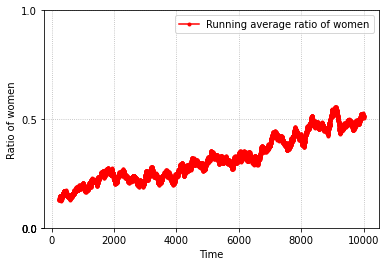

1.0151875862453832
0.0075054098746451525


In [6]:
def temporal_bias():
    n = 10_000
    
    data = generate_toy_data(n)
    
    def hype(h):
        return (np.asarray(h) / n)
    
    def time(t):
        from scipy.stats import norm
        return (np.round(norm.rvs(loc=t/2, scale=0.5)))
    
    data = Bias.TemporalBiasGenerator(parameter="sex", 
                                       primary_distribution=time, 
                                       hype_distribution=hype,
                                       domain=[0, 1]).apply(data)
    
    
    import matplotlib.pyplot as plt
    x = np.linspace(0, n, n)
    y = data.df()["sex"]
    window = 250
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))
    for ind in range(window - 1):
        average_y.insert(0, np.nan)
        
    plt.plot(x, average_y, 'r.-', label='Running average ratio of women')
    plt.yticks([0, 0, 0, 0.5, 1])
    plt.grid(linestyle=':')
    plt.xlabel("Time")
    plt.ylabel("Ratio of women")
    plt.legend()
    plt.show()
    
    print(data.metrics().disparate_impact())
    print(data.metrics().mean_difference())
    
temporal_bias()

In [7]:
def differences(n):
    def evaluate(tmp):
        # accuracy
        X_train, X_test, y_train, y_test = tmp.train_test_split(0.2)
        model = LogisticRegression(max_iter=200)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)       
        print(f"Accuracy: {accuracy_score(y_test, preds)*100:.2f}%")
        
        # metrics
        m = tmp.metrics()
        print(f"Disparate Impact: {m.disparate_impact():.3f}")
        print(f"Mean Difference: {m.mean_difference():.3f}")
        
        # distribution
        print(tmp.df(weight=False).groupby(["sex", "loan"])["history"].count())
        print(tmp.df(weight=False).value_counts())
        print()
        
    def difference(meas, samp):
        def train_model(data,r=1):
            X_train, X_test, y_train, y_test = data.train_test_split(0.2, seed=r)
            model = LogisticRegression(random_state=r)
            model.fit(X_train, y_train)
            return model, X_test, y_test
        
        acc = [0, 0, 0, 0]
        for i in range(10):
            M = train_model(meas, i)
            S = train_model(samp, i)
            
            acc[0] += accuracy_score(M[2], M[0].predict(M[1]))
            acc[1] += accuracy_score(S[2], M[0].predict(S[1]))
            acc[2] += accuracy_score(S[2], S[0].predict(S[1]))
            acc[3] += accuracy_score(M[2], S[0].predict(M[1]))

        print(f"Measurement accuracy: {acc[0] / 10}")
        print(f"Measurement accuracy on sampling: {acc[1] / 10}")
        print(f"Sampling accuracy: {acc[2] / 10}")
        print(f"Sampling accuracy on measurement: {acc[3] / 10}")
        
        print("======")        
        im = 0
        for i in range(10):
            M = train_model(meas, i)
            M2 = train_model(meas, i * 2)
            
            p1 = M[0].predict_proba(M[1][:20000])[:,1]
            p2 = M2[0].predict_proba(M[1][:20000])[:,1]
            
            im += np.average(np.abs(p1 - p2))
        print(f"intra meas: {im / 10}")
        
        
        im = 0
        for i in range(10):
            S = train_model(samp, i)
            S2 = train_model(samp, i * 2)
            
            p1 = M[0].predict_proba(S[1][:20000])[:,1]
            p2 = M2[0].predict_proba(S[1][:20000])[:,1]
            
            im += np.average(np.abs(p1 - p2))
        print(f"intra samp: {im / 10}")
        
        
        im = 0
        for i in range(10):
            M = train_model(meas, i)
            S = train_model(samp, i)
            
            p1 = M[0].predict_proba(M[1])[:,1]
            p2 = S[0].predict_proba(M[1])[:,1]
            im += np.average(np.abs(p1 - p2))

            p1 = M[0].predict_proba(S[1])[:,1]
            p2 = S[0].predict_proba(S[1])[:,1]
            im += np.average(np.abs(p1 - p2))
        
        print(f"inter samp n meas: {im / 20}")
        
        
        
    measurement = generate_toy_data(n)
    
    sampling = generate_toy_data(int(n*1.25))
    
    print(len(measurement))
    evaluate(measurement)
    
    measurement_bias = Bias.MeasurementBiasGenerator(parameter="sex",
                                                    parameter_value=0,
                                                    measurement="sex",
                                                    weight={
                                                        "invalid_ratio":0,
                                                        "measurement_error":[0, 1]
                                                    },
                                                    bias_strength=0.25,
                                                    seed=RANDOM_STATE).apply(measurement)
    
    evaluate(measurement_bias)
    
    measurement_bias = Bias.MeasurementBiasGenerator(parameter="sex",
                                                    parameter_value=0,
                                                    measurement="loan",
                                                    weight={
                                                        "invalid_ratio":0,
                                                        "measurement_error":[1, 0]
                                                    },
                                                    bias_strength=0.34,
                                                    seed=RANDOM_STATE).apply(measurement_bias)
    print(len(measurement_bias))
    evaluate(measurement_bias)
    
    print("=================")
    
    print(len(sampling))
    evaluate(sampling)
    sampling_bias = Bias.SamplingBiasGenerator(parameter="sex",
                                              parameter_value=0,
                                              weight={"loan": {0: 1/3, 1:1}},
                                              bias_strength=0.6,
                                              seed=RANDOM_STATE).apply(sampling)
    print(len(sampling_bias))
    evaluate(sampling_bias)
    
    print("===============")
    
    difference(measurement_bias, sampling_bias)
    

differences(100_000)

  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


  0%|          | 0/4 [00:00<?, ?it/s]

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


100000
Accuracy: 58.40%
Disparate Impact: 1.006
Mean Difference: 0.003
sex  loan
0    0       25014
     1       25195
1    0       24949
     1       24842
Name: history, dtype: int64
loan  sex  income  history
1     0    0       1          12347
0     0    0       1          12289
1     1    0       1          12184
0     1    0       1          12128
1     0    1       1           7368
0     0    0       0           7330
      1    0       0           7303
1     1    1       1           7273
0     1    1       1           3205
      0    1       1           3151
1     0    0       0           3113
      1    0       0           3099
      0    1       0           2367
0     1    1       0           2313
1     1    1       0           2286
0     0    1       0           2244
dtype: int64

Accuracy: 58.26%
Disparate Impact: 0.999
Mean Difference: -0.001
sex  loan
0    0       18828
     1       18829
1    0       31135
     1       31208
Name: history, dtype: int64
loan  sex  income  